In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers 

     |████████████████████████████████| 2.8 MB 4.1 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 3.3 MB 19.1 MB/s 
     |████████████████████████████████| 636 kB 50.0 MB/s 
     |████████████████████████████████| 895 kB 37.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
#import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score

import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
filePath = '/content/drive/MyDrive/HASOC/data/english/english_2021.csv'
df1 = pd.read_csv(filePath,delimiter=',')

df1 = df1.drop('task_2',axis=1)
df1.columns = ['TwitterID','HASOCID','Text','Type']
df1 = df1.drop(['TwitterID','HASOCID'],axis=1)

filePath = '/content/drive/MyDrive/HASOC/data/english/english_2020.xlsx'
df2 = pd.read_excel(filePath)

df2 = df2.drop('task2',axis=1)
df2.columns = ['TwitterID','Text','Type','HASOCID']
df2 = df2.drop(['TwitterID','HASOCID'],axis=1)


filePath = '/content/drive/MyDrive/HASOC/data/english/english_2019_1.tsv'
df3 = pd.read_csv(filePath,delimiter='\t')

df3 = df3.drop(['text_id','task_2','task_3'],axis=1)
df3.columns = ['Text','Type']

filePath = '/content/drive/MyDrive/HASOC/data/english/english_2019_2.tsv'
df4 = pd.read_csv(filePath,delimiter='\t')

df4 = df4.drop(['text_id','task_2','task_3'],axis=1)
df4.columns = ['Text','Type']

In [6]:
df = pd.concat([df1,df2,df3,df4])

In [7]:
df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.codes
df['Type'] = df['Type'].astype(np.int64)

In [8]:
X = list(df['Text'].values)
y = list(df['Type'].values)

In [9]:
# Train ~ 80%
# Validation ~ 10%
# Test = 10%

X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = 0.10, random_state=42,stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_tmp, y_tmp, test_size = 0.111, random_state=42,stratify=y_tmp)

print(len(X_train))
print(len(X_valid))
print(len(X_test))

11645
1455
1456


In [10]:
model_name = 'distilbert-base-uncased'

In [11]:
def generate_dataset(X,y, tokenizer):

  #Generate encodings
  encodings = tokenizer.batch_encode_plus(X,        
                                          truncation = True,
                                          padding=True,
                                          max_length=128,
                                          return_tensors='pt',
                                          add_special_tokens = True)

  #convert to tensor dataset
  input_ids = encodings['input_ids']
  attention_mask = encodings['attention_mask']

  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)
  y = torch.tensor(y)

  dataset = TensorDataset(input_ids,attention_mask,y)

  return dataset

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
train_dataset = generate_dataset(X_train,y_train,tokenizer)
valid_dataset = generate_dataset(X_valid,y_valid,tokenizer)

In [14]:
def get_data_loader(dataset,sampler):
  return DataLoader(dataset=dataset,sampler=sampler(dataset),batch_size=32)

In [15]:
# Try out weighted sampler?
train_loader = get_data_loader(train_dataset,RandomSampler)
validation_loader = get_data_loader(valid_dataset,SequentialSampler)

In [16]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.cuda()
print("Imported model!")

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

Imported model!


In [17]:
optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8)

num_epochs = 8
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [18]:
def compute_accuracy(preds,labels):
  preds = preds.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()
  preds = np.argmax(preds,axis=1).flatten()
  labels = labels.flatten()
  return np.sum(preds == labels)/len(labels)

In [19]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [20]:
def train():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  num_steps = 0

  for step,batch in enumerate(train_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

  avg_loss = total_loss/len(train_loader)
  avg_acc = total_acc/len(train_loader)

  return avg_loss,avg_acc

In [21]:
def evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(validation_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(validation_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(validation_loader)
  avg_acc = total_acc/len(validation_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

In [22]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_f1 = 0.0

for epoch in range(num_epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
  
  train_loss, train_acc = train()
  valid_loss, valid_acc,f1_score = evaluate()

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accs.append(valid_acc)

  if f1_score > best_f1:
      best_f1 = f1_score
      torch.save(model,'/content/drive/MyDrive/HASOC/data/english/final_english_model_distilbert_8Sept.pt')


  print(f'\nTraining Accuracy: {train_acc:.3f} | Training Loss: {train_loss:.3f} | Validation Accuracy: {valid_acc:.3f} | Validation Loss: {valid_loss:.3f} | F1 Score: {f1_score:.3f} ')


 Epoch 1 / 8
  Batch    50  of    364.
  Batch   100  of    364.
  Batch   150  of    364.
  Batch   200  of    364.
  Batch   250  of    364.
  Batch   300  of    364.
  Batch   350  of    364.

Training Accuracy: 0.754 | Training Loss: 0.505 | Validation Accuracy: 0.793 | Validation Loss: 0.428 | F1 Score: 0.791 

 Epoch 2 / 8
  Batch    50  of    364.
  Batch   100  of    364.
  Batch   150  of    364.
  Batch   200  of    364.
  Batch   250  of    364.
  Batch   300  of    364.
  Batch   350  of    364.

Training Accuracy: 0.818 | Training Loss: 0.402 | Validation Accuracy: 0.793 | Validation Loss: 0.438 | F1 Score: 0.792 

 Epoch 3 / 8
  Batch    50  of    364.
  Batch   100  of    364.
  Batch   150  of    364.
  Batch   200  of    364.
  Batch   250  of    364.
  Batch   300  of    364.
  Batch   350  of    364.

Training Accuracy: 0.865 | Training Loss: 0.320 | Validation Accuracy: 0.798 | Validation Loss: 0.454 | F1 Score: 0.796 

 Epoch 4 / 8
  Batch    50  of    364.
  Batc

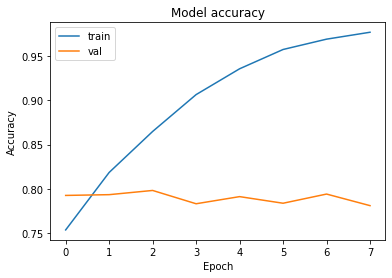

In [23]:
plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

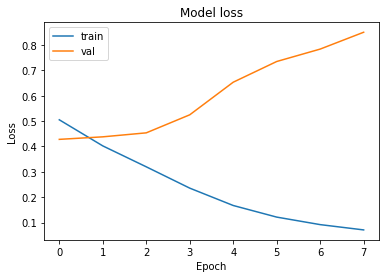

In [24]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [25]:
del model
del train_loader
del validation_loader

import gc
gc.collect()

380

In [26]:
model = torch.load('/content/drive/MyDrive/HASOC/data/english/final_english_model_distilbert_8Sept.pt')
model = model.to(device)

In [27]:
test_dataset = generate_dataset(X_test,y_test,tokenizer)
test_loader = get_data_loader(test_dataset,SequentialSampler)

In [28]:
def test_evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(test_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(test_loader)
  avg_acc = total_acc/len(test_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

In [29]:
test_loss,test_acc,f1_score = test_evaluate()
print(f'\nTest Accuracy: {test_acc:.3f} | Test Loss: {test_loss:.3f} | F1 Score: {f1_score:.3f} ')


Test Accuracy: 0.779 | Test Loss: 0.531 | F1 Score: 0.777 


In [ ]:
filePath = '/content/drive/MyDrive/HASOC/data/english/en_Hasoc2021_test_task1.csv'
df_test = pd.read_csv(filePath,delimiter=',')

In [ ]:
results = {}

for ind in df_test.index:
  txt = df_test['text'][ind]
  id = df_test['_id'][ind]

  encodings = tokenizer.encode_plus(txt,truncation = True,padding=True,max_length=128,return_tensors='pt')

  input_ids = encodings['input_ids']
  attention_mask = encodings['attention_mask']
  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    outputs = model(input_ids, attention_mask)
    outputs = outputs.logits.detach().cpu().numpy()
    outputs = np.argmax(outputs,axis=1)

    if(outputs[0]==0):
      results[id] = "HOF"
    else:
      results[id] = "NOT"

In [ ]:
df_results = pd.DataFrame(list(results.items()))
df_results.columns = ["id","label"]

In [ ]:
df_results.to_csv("/content/drive/MyDrive/HASOC/data/english/classifer_bertfinetuned_english_distilbert_30Aug.csv",index=False)